In [ ]:
# default_exp stats

# fullstream.stats

> Module for statistical computation in the context of particle physics inference.

In [ ]:
#export
import pyhf
pyhf.set_backend(pyhf.tensor.jax_backend())
import numpy as onp
import jax.numpy as np

In [ ]:
#export
def hists_from_nn(nn, params, sigevents, bkgevents, scale=False, use_jax=True):
    '''Create nn-based binned summary statistics from signal and background events. 
    nn should be a predict method that's callable on arguments (data,params), and have a logsoftmax output.'''
    
    # set some arbitrary scale factors
    # todo change
    sig_sf = 0.02 if scale else 1 
    bkg_sf = 0.1 if scale else 1

    sighist = np.sum(np.exp(nn(sigevents,params)),axis=0)*sig_sf
    bkghist = np.sum(np.exp(nn(bkgevents,params)),axis=0)*bkg_sf
    
    if use_jax:
        return sighist, bkghist
    else:
        return onp.asarray(sighist), onp.asarray(bkghist)

In [ ]:
from fullstream.nn import simple_classifier

/home/phinate/envs/fullstream/lib/python3.7/site-packages/jax-0.1.58-py3.7.egg/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.


In [ ]:
x = simple_classifier(dist=3)

In [ ]:
x.train()


Starting training...
Epoch 0 in 3.20 sec
Training set accuracy 0.87475
Epoch 1 in 2.76 sec
Training set accuracy 0.9105
Epoch 2 in 2.81 sec
Training set accuracy 0.9246


In [ ]:
sighist, bkghist = hists_from_nn(x, x.params, x.gen_sig(1000), x.gen_bkg(1000), scale=True, use_jax=True)[0]

- 0 --> NN thinks it's background
- 1 --> NN thinks it's signal

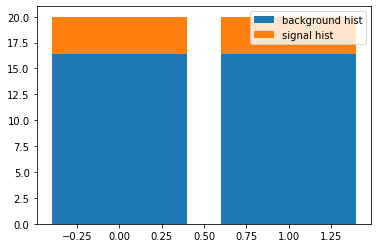

In [ ]:
import matplotlib.pyplot as plt
plt.bar([0,1], bkghist, label='background hist')
plt.bar([0,1], sighist, bottom=bkghist, label='signal hist')
plt.legend()

In [ ]:
#export
def simple_nn_logpdf(nn_pars,nn,pars,data,sig_data,bkg_data,bkg_uncerts,use_jax=False):
        '''Return pyhf.Model.logpdf for a simple two-bin model, containing a signal and background histogram created using hists_from_nn.'''
        tensorlib, _ = pyhf.get_backend()
        
        sig_hist, bkg_hist = hists_from_nn(nn, nn_pars, sig_data, bkg_data, scale=True, use_jax=use_jax) 
        
        spec = {
        'channels': [
            {
                'name': 'singlechannel',
                'samples': [
                    {
                        'name': 'signal',
                        'data': sig_hist,
                        'modifiers': [
                            {'name': 'mu', 'type': 'normfactor', 'data': None}
                        ],
                    },
                    {
                        'name': 'background',
                        'data': bkg_hist,
                        'modifiers': [
                            {
                                'name': 'uncorr_bkguncrt',
                                'type': 'shapesys',
                                'data': bkg_hist,
                            }
                        ],
                    },
                ],
            }
        ]
    }
        model = pyhf.Model(spec)
        print(spec)
        data += model.config.auxdata
        data = tensorlib.astensor(data)
        pars = tensorlib.astensor(pars)

        # grad only defined for scalar output functions, not [scalar]
        return model.logpdf(pars,data)[0]

In [ ]:
from jax import grad

In [ ]:
# with numpy
simple_nn_logpdf(x.params,
                 nn=x,
                 pars=[1.,1.,1.],
                 data=[100.,20.],
                 sig_data=x.gen_sig(1000),
                 bkg_data=x.gen_bkg(1000),
                 bkg_uncerts=[7,7],
                 use_jax=False)

{'channels': [{'name': 'singlechannel', 'samples': [{'name': 'signal', 'data': array([ 3.57937456, 16.42062544]), 'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]}, {'name': 'background', 'data': array([90.37500699,  9.62499301]), 'modifiers': [{'name': 'uncorr_bkguncrt', 'type': 'shapesys', 'data': array([90.37500699,  9.62499301])}]}]}]}


DeviceArray(-8.59706471, dtype=float64)

In [ ]:
# with jax
grad(simple_nn_logpdf)(x.params,
                       nn=x,
                       pars=[1.,1.,1.],
                       data=[100.,20.],
                       sig_data=x.gen_sig(1000),
                       bkg_data=x.gen_bkg(1000),
                       bkg_uncerts=[7,7],
                       use_jax=True)

{'channels': [{'name': 'singlechannel', 'samples': [{'name': 'signal', 'data': Traced<ConcreteArray([ 3.57937456 16.42062544])>with<JVPTrace(level=1/0)>, 'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]}, {'name': 'background', 'data': Traced<ConcreteArray([90.37500699  9.62499301])>with<JVPTrace(level=1/0)>, 'modifiers': [{'name': 'uncorr_bkguncrt', 'type': 'shapesys', 'data': Traced<ConcreteArray([90.37500699  9.62499301])>with<JVPTrace(level=1/0)>}]}]}]}


[(DeviceArray([[-1.23084869e+01,  5.56208658e+00,  3.23549932e-04,
                 1.93820204e-04,  1.36456175e+01,  0.00000000e+00,
                 0.00000000e+00, -1.01762481e-07,  0.00000000e+00,
                 1.39686184e+01],
               [-1.67865543e+01,  7.58433676e+00,  9.15458295e-05,
                 5.29033168e-05,  1.86071892e+01,  0.00000000e+00,
                 0.00000000e+00,  6.07859306e-07,  0.00000000e+00,
                 1.90502663e+01]], dtype=float32),
  DeviceArray([-3.3381634e+00,  1.5081198e+00,  4.9363494e-05,
                3.0261819e-05,  3.6999438e+00,  0.0000000e+00,
                0.0000000e+00,  1.4742641e-07,  0.0000000e+00,
                3.7882504e+00], dtype=float32)),
 (),
 (DeviceArray([[ 7.3315840e+00, -7.3315840e+00],
               [ 2.1346252e+00, -2.1346252e+00],
               [ 3.3933472e-06, -3.3933472e-06],
               [ 5.3991002e-06, -5.3991002e-06],
               [ 4.8403034e+00, -4.8403034e+00],
               [ 0.000000

In [ ]:
#export
def hists_from_nn_uncert(nn, params, sig, bkg1, bkg2, scale=True, use_jax=True):
    '''Create nn-based binned summary statistics from signal and background events. 
    nn should be a predict method that's callable on arguments (data,params), and have a logsoftmax output.'''
    
    # set some arbitrary scale factors
    # todo change
    sig_sf = 0.02 if scale else 1 
    bkg_sf = 0.1 if scale else 1

    sighist = np.sum(np.exp(nn(sig,params)),axis=0)*sig_sf
    b1 = np.sum(np.exp(nn(bkg1,params)),axis=0)*bkg_sf
    b2 = np.sum(np.exp(nn(bkg2,params)),axis=0)*bkg_sf

    bkghist = np.mean((b1,b2),axis=0)
    bkguncert = np.abs((b1-b2)/2.)
    if use_jax:
        return sighist, bkghist,bkguncert 
    else:
        return onp.asarray(sighist), onp.asarray(bkghist)

In [ ]:
def get_event_data(keys=[1,2,3]):
    k1,k2,k3 = keys
    sig  = jax.random.multivariate_normal(jax.random.PRNGKey(k1), jax.numpy.asarray([2,5]), jax.numpy.asarray([[1,0.],[0.,1]]),shape=(1,5000))[0]
    bkg1 = jax.random.multivariate_normal(jax.random.PRNGKey(k2), jax.numpy.asarray([4,6]), jax.numpy.asarray([[1,0.6],[0.6,1]]),shape=(1,5000))[0]
    bkg2 = jax.random.multivariate_normal(jax.random.PRNGKey(k3), jax.numpy.asarray([5.5,4.5]), jax.numpy.asarray([[1.7,0.2],[0.2,1]]),shape=(1,5000))[0]
    return sig,bkg1,bkg2


hists_from_nn_uncert(nn, params, sig, bkg1, bkg2)

In [ ]:
def nn_model(nn,nn_pars,pars,data,sig_data,bkg_data1,bkg_data2,use_jax=True):
        '''Return pyhf.Model.logpdf for a simple two-bin model, containing a signal and background histogram created using hists_from_nn.'''
        tensorlib, _ = pyhf.get_backend()
        
        sig_hist, bkg_hist bkg_uncert = hists_from_nn_uncert(nn, nn_pars, sig_data, bkg_data1, bkg_data2, scale=True, use_jax=use_jax) 
        
        spec = {
            'channels': [
                {
                    'name': 'singlechannel',
                    'samples': [
                        {
                            'name': 'signal',
                            'data': sig_hist,
                            'modifiers': [
                                {'name': 'mu', 'type': 'normfactor', 'data': None}
                            ],
                        },
                        {
                            'name': 'background',
                            'data': bkg_hist,
                            'modifiers': [
                                {
                                    'name': 'uncorr_bkguncrt',
                                    'type': 'shapesys',
                                    'data': bkg_uncert,
                                }
                            ],
                        },
                    ],
                }
            ]
        }
        model = pyhf.Model(spec)
        print(spec)
        data += model.config.auxdata
        data = tensorlib.astensor(data)
        pars = tensorlib.astensor(pars)

        # grad only defined for scalar output functions, not [scalar]
        return model.logpdf(pars,data)[0]